In [2]:
import pandas as pd
import category_encoders as ce

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from itables import show
from ridgeReg import RidgeReg

In [3]:
df = pd.read_csv("dataset.csv", index_col=0)
df = df.drop('track_id',axis=1)
df["explicit"] = df["explicit"].astype(int)

In [4]:
def test_train_split(df,random_state=1):
  df_train = df.sample(frac=0.8,random_state=random_state)
  df_train_x = df_train.drop('popularity',axis=1)
  df_train_y = df_train['popularity']

  df_test = df.drop(df_train.index)
  df_test_x = df_test.drop('popularity',axis=1)
  df_test_y = df_test['popularity']
  return (df_train_x,df_train_y,df_test_x,df_test_y)

In [5]:
def test_my_ridge(train_x,train_y,test_x,test_y,alpha=0,print_pred=False):
  ridge = RidgeReg(alpha)
  print('Training ridge regression...')
  ridge.fit(train_x,train_y)

  print('Predicting values...')
  pred = ridge.predict(test_x)
  if(print_pred):
    print('Predictions: ')
    print([(x,y) for (x,y) in zip(test_y,pred)])
  pred_train = ridge.predict(train_x)

  score_test = ridge.r2_score(test_y,pred)
  mse_test = ridge.mse(test_y,pred)
  score_train = ridge.r2_score(train_y,pred_train)
  mse_train = ridge.mse(train_y,pred_train)
  print(f'R2 score: {score_train, score_test}')
  print(f'MSE: {mse_train, mse_test}')
  return score_train,score_test,mse_train,mse_test

In [6]:
def k_fold_testing(df,encoder,alpha=0,random_state=1):
  X = df.drop('popularity',axis=1)
  y = df['popularity']
  kf = KFold(n_splits=5,shuffle=True,random_state=random_state)
  train_scores = []
  test_scores = []
  train_mse = []
  test_mse = []
  for (train_index,test_index) in kf.split(df):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    if(encoder.needs_y):
      enc = encoder.fit(X_train,y_train)
    else:
      enc = encoder.fit(X_train)
    
    df_train_x = enc.transform(X_train)
    df_test_x = enc.transform(X_test)

    scaler = StandardScaler()
    scaler.fit(df_train_x)
    df_train_x = pd.DataFrame(scaler.transform(df_train_x),columns=df_train_x.columns)
    df_test_x = pd.DataFrame(scaler.transform(df_test_x),columns=df_test_x.columns)

    #enc2 = ce.OneHotEncoder(cols=['track_genre']).fit(bin_df_train_x)
    #bin_df_train_x = enc2.transform(bin_df_train_x)
    #bin_df_test_x = enc2.transform(bin_df_test_x)
    score = test_my_ridge(df_train_x,y_train,df_test_x,y_test,alpha)
    train_scores.append(score[0])
    test_scores.append(score[1])
    train_mse.append(score[2])
    test_mse.append(score[3])
  print(train_scores)
  print(sum(train_scores)/len(train_scores)) # 0.014007646151338538
  print(test_scores)
  print(sum(test_scores)/len(test_scores)) # -0.0378098150148428
  print(train_mse)
  print(sum(train_mse)/len(train_mse))
  print(test_mse)
  print(sum(test_mse)/len(test_mse))
  return (train_scores,test_scores,train_mse,test_mse)


# One Hot Encoder

In [7]:
#enc = ce.OneHotEncoder(cols=['artists']).fit(df)
#genre = enc.transform(df)
#genre

# Binary encoder

In [8]:
encoder = ce.BinaryEncoder(cols=['artists','track_name','album_name','track_genre'])
encoder.needs_y = False
bin_train_r2,bin_test_r2,bin_train_mse,bin_test_mse = k_fold_testing(df,encoder,0,1)

Training ridge regression...
Predicting values...
R2 score: (0.19083810970745096, -0.15175128359823153)
MSE: (402.2860751678762, 574.6145497372029)
Training ridge regression...
Predicting values...
R2 score: (0.19677440017030579, -0.17163943410379412)
MSE: (399.3093031488546, 584.612555837934)
Training ridge regression...
Predicting values...
R2 score: (0.19532022590275322, -0.13973137289006332)
MSE: (400.61142497303945, 565.4778886000514)
Training ridge regression...
Predicting values...
R2 score: (0.19569767933551707, -0.15120508615360273)
MSE: (399.47897982378123, 576.4475093976561)
Training ridge regression...
Predicting values...
R2 score: (0.1925646187605029, -0.15523665163262224)
MSE: (402.6880459135743, 569.1124372318458)
[0.19083810970745096, 0.19677440017030579, 0.19532022590275322, 0.19569767933551707, 0.1925646187605029]
0.19423900677530598
[-0.15175128359823153, -0.17163943410379412, -0.13973137289006332, -0.15120508615360273, -0.15523665163262224]
-0.15391276567566278
[40

# Ordinal encoder

In [9]:
encoder = ce.OrdinalEncoder(cols=['artists','track_name','album_name','track_genre'])
encoder.needs_y = False
ord_train_r2,ord_test_r2,ord_train_mse,ord_test_mse = k_fold_testing(df,encoder,0,1)

Training ridge regression...
Predicting values...
R2 score: (0.14377365867285752, -0.11132785929312305)
MSE: (425.684820850019, 554.4470985811263)
Training ridge regression...
Predicting values...
R2 score: (0.14656445483773162, -0.10973250790879874)
MSE: (424.27028333442547, 553.7228765616385)
Training ridge regression...
Predicting values...
R2 score: (0.14720422656249754, -0.10512557608770479)
MSE: (424.56607088336665, 548.3082174173597)
Training ridge regression...
Predicting values...
R2 score: (0.1468420482497793, -0.11289341706486611)
MSE: (423.74447945413607, 557.2635546942778)
Training ridge regression...
Predicting values...
R2 score: (0.14614199061997546, -0.11525196403135674)
MSE: (425.8401616697411, 549.4144965713319)
[0.14377365867285752, 0.14656445483773162, 0.14720422656249754, 0.1468420482497793, 0.14614199061997546]
0.1461052757885683
[-0.11132785929312305, -0.10973250790879874, -0.10512557608770479, -0.11289341706486611, -0.11525196403135674]
-0.11086626487716988
[42

# Target Encoder

In [10]:
encoder = ce.TargetEncoder(cols=['artists','track_name','album_name','track_genre'])
encoder.needs_y = True
tgt_train_r2,tgt_test_r2,tgt_train_mse,tgt_test_mse = k_fold_testing(df,encoder,0,1)

Training ridge regression...
Predicting values...
R2 score: (0.7373190149199436, 0.6464286729689759)
MSE: (130.59550106948535, 176.39852611858566)
Training ridge regression...
Predicting values...
R2 score: (0.7388173300106382, 0.6449638564151773)
MSE: (129.84231325560614, 177.15227165832962)
Training ridge regression...
Predicting values...
R2 score: (0.7391395375751739, 0.6413950601877361)
MSE: (129.8698997229998, 177.9218937286792)
Training ridge regression...
Predicting values...
R2 score: (0.7363277064832751, 0.6479116365698272)
MSE: (130.96013291971747, 176.3026090037091)
Training ridge regression...
Predicting values...
R2 score: (0.7357350284209967, 0.65165886727977)
MSE: (131.79549408052316, 171.60576644650652)
[0.7373190149199436, 0.7388173300106382, 0.7391395375751739, 0.7363277064832751, 0.7357350284209967]
0.7374677234820055
[0.6464286729689759, 0.6449638564151773, 0.6413950601877361, 0.6479116365698272, 0.65165886727977]
0.6464716186842973
[130.59550106948535, 129.8423132

# Cat Boost Encoder

In [11]:
encoder = ce.CatBoostEncoder(cols=['artists','track_name','album_name','track_genre'])
encoder.needs_y = True
cat_train_r2,cat_test_r2,cat_train_mse,cat_test_mse = k_fold_testing(df,encoder,0,1) 

Training ridge regression...
Predicting values...
R2 score: (0.8189643604849826, 0.7224156125320603)
MSE: (90.00438325101068, 138.48825704856574)
Training ridge regression...
Predicting values...
R2 score: (0.8192476501909992, 0.7181535460071109)
MSE: (89.85781187757638, 140.63283551793185)
Training ridge regression...
Predicting values...
R2 score: (0.8200502974913257, 0.7145435180642336)
MSE: (89.58831707476516, 141.62927557475084)
Training ridge regression...
Predicting values...
R2 score: (0.8187813788195157, 0.7174553280405134)
MSE: (90.00723739606256, 141.47971929902693)
Training ridge regression...
Predicting values...
R2 score: (0.8186146377114938, 0.7237057264940332)
MSE: (90.46137783206589, 136.11281044967035)
[0.8189643604849826, 0.8192476501909992, 0.8200502974913257, 0.8187813788195157, 0.8186146377114938]
0.8191316649396633
[0.7224156125320603, 0.7181535460071109, 0.7145435180642336, 0.7174553280405134, 0.7237057264940332]
0.7192547462275903
[90.00438325101068, 89.8578118

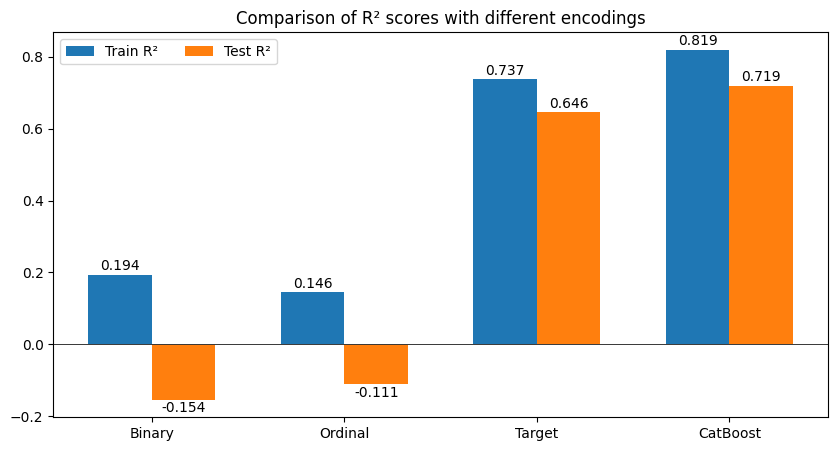

In [74]:
import matplotlib.pyplot as plt
import numpy as np

train_r2 = [bin_train_r2,ord_train_r2,tgt_train_r2,cat_train_r2]
test_r2 = [bin_test_r2]
train_mse = [bin_train_mse]
test_mse = [bin_test_mse]
data = {
  'Train R²': list(map(np.mean,[bin_train_r2,ord_train_r2,tgt_train_r2,cat_train_r2])),
  'Test R²': list(map(np.mean,[bin_test_r2,ord_test_r2,tgt_test_r2,cat_test_r2])),
}
x = np.arange(4)
width = 0.33
multiplier = 0
plt.rcParams["figure.figsize"] = (10,5)
fig,ax = plt.subplots()
for attribute,measurements in data.items():
  offset = width*multiplier
  rects = ax.bar(x+offset,measurements,width,label=attribute)
  ax.bar_label(rects, padding=1,fmt='%.3f')
  multiplier+=1
ax.axhline(0,color='#373737',linewidth=0.7) # x = 0
ax.set_xticks(x+width/2, ['Binary','Ordinal','Target','CatBoost'])
ax.legend(loc='upper left', ncols=3)
ax.set_title('Comparison of R² scores with different encodings')
plt.show()


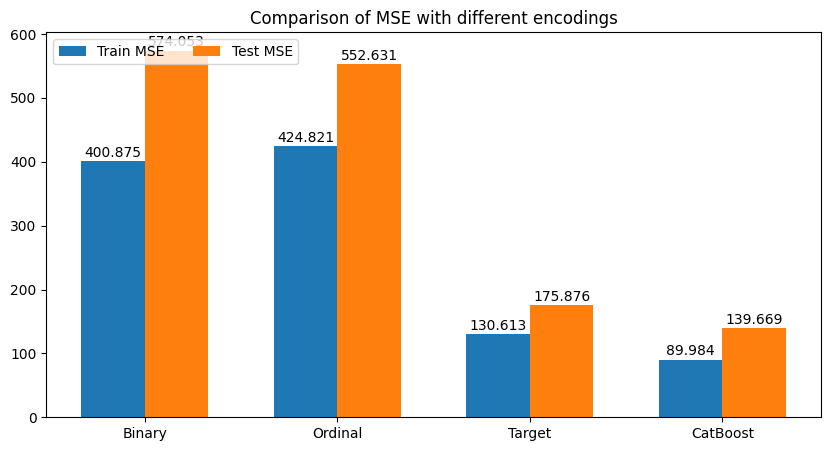

In [75]:
import matplotlib.pyplot as plt
import numpy as np

train_r2 = [bin_train_r2,ord_train_r2,tgt_train_r2,cat_train_r2]
test_r2 = [bin_test_r2]
train_mse = [bin_train_mse]
test_mse = [bin_test_mse]
data = {
  'Train MSE': list(map(np.mean,[bin_train_mse,ord_train_mse,tgt_train_mse,cat_train_mse])),
  'Test MSE': list(map(np.mean,[bin_test_mse,ord_test_mse,tgt_test_mse,cat_test_mse])),
}
x = np.arange(4)
width = 0.33
multiplier = 0
plt.rcParams["figure.figsize"] = (10,5)
fig,ax = plt.subplots()
for attribute,measurements in data.items():
  offset = width*multiplier
  rects = ax.bar(x+offset,measurements,width,label=attribute)
  ax.bar_label(rects, padding=1,fmt='%.3f')
  multiplier+=1
ax.axhline(0,color='#373737',linewidth=0.7) # x = 0
ax.set_xticks(x+width/2, ['Binary','Ordinal','Target','CatBoost'])
ax.legend(loc='upper left', ncols=3)
ax.set_title('Comparison of MSE with different encodings')
plt.show()


In [47]:
#encoder = ce.BaseNEncoder(cols=['artists','track_name','album_name','track_genre'],base=2)
#encoder.needs_y = False
#tgt_train_r2,tgt_test_r2,tgt_train_mse,tgt_test_mse = k_fold_testing(df,encoder,0,1)

Failed: Backward Difference, Helmert, Polynomial, Sum